<div id="singlestore-header" style="display: flex; background-color: rgba(255, 167, 103, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/crystal-ball.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Real Time Recommendation Engine</h1>
    </div>
</div>

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Note</b></p>
        <p>This notebook can be run on a Free Starter Workspace. To create a Free Starter Workspace navigate to <tt>Start</tt> using the left nav. You can also use your existing Standard or Premium workspace with this Notebook.</p>
    </div>
</div>

# How to build a real-time recommendation engine with SingleStore & Vercel

We will demonstrate how to build a modern real-time AI application for free using a Shared Tier Database, SingleStore Notebooks, and Job Service.

A Free SingleStore Starter Workspace enables you to execute hybrid search, real-time analytics, and point read/writes/updates in a single database. With SingleStore Notebooks and our Job Service, you easily bring in data from various sources (APIs, MySQL / Mongo endpoints) in real-time. You can also execute Python-based transforms, such as adding embeddings, ensuring that real-time data is readily available for your downstream LLMs and applications.

We will showcase the seamless transition from a prototype to an end-application using SingleStore. The final application will be hosted on Vercel. You can see the App we've built following this notebook [here](https://llm-recommender.vercel.app/)
### Architecture:

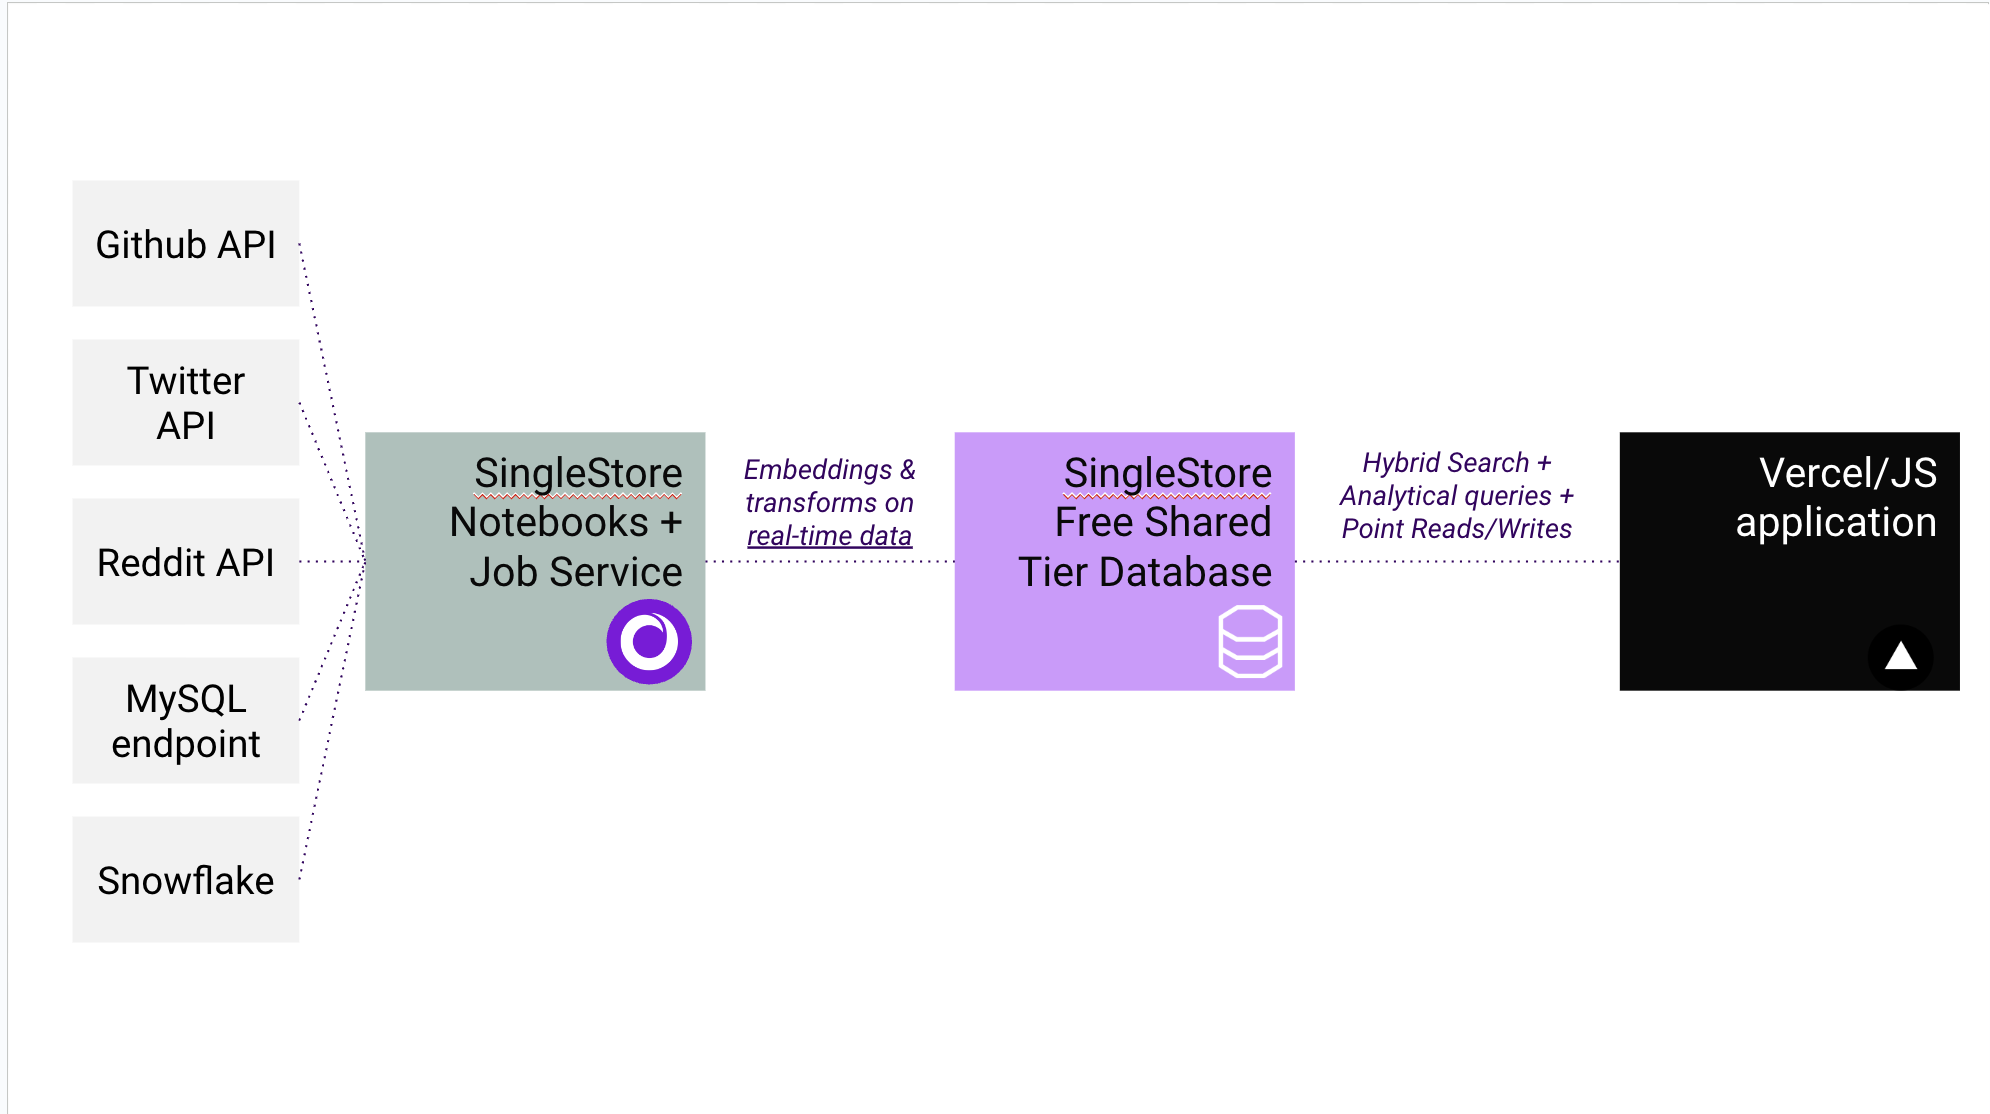

### Scenario:
Building a recommendation engine on what LLM you should be using for your use-case. Bringing together semantic search + real-time analytics on the performance of the LLM to make the recommendations.

Here are the requirements we've set out for this recommendation engine:
1. Pull data from [Hugging Face Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)  on various Open source LLM models and their scores. Pull updated scores on these models every hour.
2. For each of these models, pull data from Twitter and Github on what developers are saying about these models, and how they are being used in active projects. Pull this data every hour.
3. Provide an easy 'search' interface to users where they can describe their use-case. When users provide describe their use-case, perform a hybrid search (vector + full-text search) across the descriptions of these models, what users are saying about it on Twitter, and which github repos are using these LLMs.
4. Combine the results of the semantic search with analytics on the public benchmarks, # likes, # downloads of these models.
6. Power the app entirely on a single SingleStore Free Shared Tier Workspace.
7. Ensure that all of the latest posts / scores are reflected in the App. Power this entirely with SingleStore Notebook and Job Service

### Contents
- Step 1: Creating a Starter Workspace
- Step 2: Installing & Importing required libraries
- Step 3: Setting Key Variables
- Step 4: Designing your table scheama on SingleStore
- Step 5: Creating Helper Functions to load data into SingleStore
- Step 6: Loading data with embeddings into SingleStore
- Step 7: Building the Recommendation Engine Algorithm on Vercel

## Step 1. Create a Starter Workspace

Create a new Workpsace Group and select a Starter Workspace. If you do not have this enabled email pm@singlestore.com

## Step 2. Install and import required libraries

In [1]:
%pip install singlestoredb openai tiktoken beautifulsoup4 pandas python-dotenv Markdown praw tweepy --quiet

import re
import json
import openai
import tiktoken
import json
import requests
import getpass
import pandas as pd
import singlestoredb as s2
import tweepy
import praw
from bs4 import BeautifulSoup
from markdown import markdown
from datetime import datetime
from time import time, sleep

## Step 3. Seting Environment variables

### 3.1. Set the app common variables. Do not change these

In [2]:
MODELS_LIMIT = 100
MODELS_TABLE_NAME = 'models'
MODEL_READMES_TABLE_NAME = 'model_readmes'
MODEL_TWITTER_POSTS_TABLE_NAME = 'model_twitter_posts'
MODEL_REDDIT_POSTS_TABLE_NAME = 'model_reddit_posts'
MODEL_GITHUB_REPOS_TABLE_NAME = 'model_github_repos'
LEADERBOARD_DATASET_URL = 'https://llm-recommender.vercel.app/datasets/leaderboard.json'
TOKENS_LIMIT = 2047
TOKENS_TRASHHOLD_LIMIT = TOKENS_LIMIT - 128

### 3.2. Set the OpenAI variables

We will be using OpenAI's embedding models to create vectors representing our data. The vectors will be stored in the SingleStore Starter Workspace as a column in the relevant tables.

Using OpenAI's LLMs we will also generate output text after we complete the Retrieval Augmentation Generation Steps.
1. [Open the OpenAI API keys page](https://platform.openai.com/api-keys)
2. Create a new key
3. Copy the key and paste it into the `OPENAI_API_KEY` variable

In [3]:
OPENAI_API_KEY = getpass.getpass("enter openAI apikey here")

### 3.3. Set the HuggingFace variables

We will be pulling data from HugginFace about the different models, the usage of these models, and how they score in several evaluation metrics.
1. [Open the HuggingFace Access Tokens page](https://huggingface.co/settings/tokens)
2. Create a new token
3. Copy the key and paste it into the `HF_TOKEN` variable

In [4]:
HF_TOKEN = getpass.getpass("enter HuggingFace apikey here")

### 3.4. Set the Twitter variables
We will be pulling data from Twitter about what users might be saying about these models. Since teh quality of these models may change over time, we want to caputre the sentiment of what people are talking about and using on twitter.
1. [Open the Twitter Developer Projects & Apps page](https://developer.twitter.com/en/portal/projects-and-apps)
2. Add a new app
3. Fill the form
4. Generate a Bearer Token and paste it into the `TWITTER_BEARER_TOKEN` variable

In [5]:
TWITTER_BEARER_TOKEN = getpass.getpass("enter Twitter Bearer Token here")

### 3.5 Set the GitHub variables
We will also be pulling data from various Github repos on which models are being referenced and used for which scenarios.
1. [Open the Register new GitHub App page](https://github.com/settings/apps/new)
2. Fill the form
3. Get an access token and paste it into the `GITHUB_ACCESS_TOKEN` variable

In [6]:
GITHUB_ACCESS_TOKEN = getpass.getpass("enter Github Access Token here")

## Step 4. Designing and creating your table schemas in SingleStore

We will be storing all of this data in a single Free Shared Tier Database. Through this database, you can write hybrid search queries, run analytics on the model's performance, and get real-time reads/updates.

- `connection` - database connection to execute queries
- `create_tables` - function that creates empty tables in the database
- `drop_table` - helper function to drop a table
- `get_models` - helper function to get models from the models table
- `db_get_last_created_at` - helper function to get last `created_at` value from a table

The `create_tables` creates the following tables:
- `models_table` - table with all models data from the [Open LLM Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)
- `readmes_table` - table with model readme texts from the HugginFace model pages (used in semantic search)
- `twitter_posts` - table with tweets related to models (used in semantic search)
- `github_repos` - table with GitHub readme texts related to models (used in semantic search)

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> Make sure to select a database from the drop-down menu at the top of this notebook. It updates the <tt>connection_url</tt>  to connect to that database.</p>
    </div>
</div>

In [7]:
connection = s2.connect(connection_url)


def create_tables():
    def create_models_table():
        with connection.cursor() as cursor:
            cursor.execute(f'''
                CREATE TABLE IF NOT EXISTS {MODELS_TABLE_NAME} (
                    id INT AUTO_INCREMENT PRIMARY KEY,
                    name VARCHAR(512) NOT NULL,
                    author VARCHAR(512) NOT NULL,
                    repo_id VARCHAR(1024) NOT NULL,
                    score DECIMAL(5, 2) NOT NULL,
                    arc DECIMAL(5, 2) NOT NULL,
                    hellaswag DECIMAL(5, 2) NOT NULL,
                    mmlu DECIMAL(5, 2) NOT NULL,
                    truthfulqa DECIMAL(5, 2) NOT NULL,
                    winogrande DECIMAL(5, 2) NOT NULL,
                    gsm8k DECIMAL(5, 2) NOT NULL,
                    link VARCHAR(255) NOT NULL,
                    downloads INT,
                    likes INT,
                    still_on_hub BOOLEAN NOT NULL,
                    created_at TIMESTAMP,
                    embedding BLOB
                )
            ''')

    def create_model_readmes_table():
        with connection.cursor() as cursor:
            cursor.execute(f'''
                CREATE TABLE IF NOT EXISTS {MODEL_READMES_TABLE_NAME} (
                    id INT AUTO_INCREMENT PRIMARY KEY,
                    model_repo_id VARCHAR(512),
                    text LONGTEXT CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
                    clean_text LONGTEXT CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
                    created_at TIMESTAMP,
                    embedding BLOB
                )
            ''')

    def create_model_twitter_posts_table():
        with connection.cursor() as cursor:
            cursor.execute(f'''
                CREATE TABLE IF NOT EXISTS {MODEL_TWITTER_POSTS_TABLE_NAME} (
                    id INT AUTO_INCREMENT PRIMARY KEY,
                    model_repo_id VARCHAR(512),
                    post_id VARCHAR(256),
                    clean_text LONGTEXT CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
                    created_at TIMESTAMP,
                    embedding BLOB
                )
            ''')

    def create_model_github_repos_table():
        with connection.cursor() as cursor:
            cursor.execute(f'''
                CREATE TABLE IF NOT EXISTS {MODEL_GITHUB_REPOS_TABLE_NAME} (
                    id INT AUTO_INCREMENT PRIMARY KEY,
                    model_repo_id VARCHAR(512),
                    repo_id INT,
                    name VARCHAR(512) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
                    description TEXT CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
                    clean_text LONGTEXT CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
                    link VARCHAR(256),
                    created_at TIMESTAMP,
                    embedding BLOB
                )
            ''')

    create_models_table()
    create_model_readmes_table()
    create_model_twitter_posts_table()
    create_model_github_repos_table()


def drop_table(table_name: str):
    with connection.cursor() as cursor:
        cursor.execute(f'DROP TABLE IF EXISTS {table_name}')


def get_models(select='*', query='', as_dict=True):
    with connection.cursor() as cursor:
        _query = f'SELECT {select} FROM {MODELS_TABLE_NAME}'

        if query:
            _query += f' {query}'

        cursor.execute(_query)

        if as_dict:
            columns = [desc[0] for desc in cursor.description]
            return [dict(zip(columns, row)) for row in cursor.fetchall()]

        return cursor.fetchall()


def db_get_last_created_at(table, repo_id, to_string=False):
    with connection.cursor() as cursor:
        cursor.execute(f"""
            SELECT UNIX_TIMESTAMP(created_at) FROM {table}
            WHERE model_repo_id = '{repo_id}'
            ORDER BY created_at DESC
            LIMIT 1
        """)

        rows = cursor.fetchone()
        created_at = float(rows[0]) if rows and rows[0] else None

        if (created_at and to_string):
            created_at = datetime.fromtimestamp(created_at)
            created_at = created_at.strftime('%Y-%m-%dT%H:%M:%SZ')

        return created_at

## Step 5. Creating helper functions to load data into SingleStore

### 5.1. Setting up the `openai.api_key`

In [8]:
openai.api_key = OPENAI_API_KEY

### 5.2. Create the `create_embeddings` function
This function will be used to create embeddings on data based on an input to the function. We will be doing this to all data pulled from Github, HuggingFace and Twitter. The vector embeddings created will be stored in the same SingleStore table as a separate column.

In [9]:
def count_tokens(text: str):
    enc = tiktoken.get_encoding('cl100k_base')
    return len(enc.encode(text, disallowed_special={}))

def create_embedding(input):
    try:
        data = openai.embeddings.create(input=input, model='text-embedding-ada-002').data
        return data[0].embedding
    except Exception as e:
        print(e)
        return [[]]

### 5.3. Create the function/Utils to help parse the data ingested from the various sources
This is a set of functions that ensure the JSON is in the right format and can be stored in SingleStore as a JSON column. In your Free Shared Tier workspace you can bring data of various formats (JSON, Geospatial, Vector) and interact with this data with SQL and MongoDB API.

In [10]:
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, datetime):
            return obj.strftime('%Y-%m-%d %H:%M:%S')
        return super().default(obj)

def list_into_chunks(lst, chunk_size=100):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

def string_into_chunks(string: str, max_tokens=TOKENS_LIMIT):
    if count_tokens(string) <= max_tokens:
        return [string]

    delimiter = ' '
    words = string.split(delimiter)
    chunks = []
    current_chunk = []

    for word in words:
        if count_tokens(delimiter.join(current_chunk + [word])) <= max_tokens:
            current_chunk.append(word)
        else:
            chunks.append(delimiter.join(current_chunk))
            current_chunk = [word]

    if current_chunk:
        chunks.append(delimiter.join(current_chunk))

    return chunks

def clean_string(string: str):
    def strip_html_elements(string: str):
        html = markdown(string)
        soup = BeautifulSoup(html, "html.parser")
        text = soup.get_text()
        return text.strip()

    def remove_unicode_escapes(string: str):
        return re.sub(r'[^\x00-\x7F]+', '', string)

    def remove_string_spaces(strgin: str):
        new_string = re.sub(r'\n+', '\n', strgin)
        new_string = re.sub(r'\s+', ' ', new_string)
        return new_string

    def remove_links(string: str):
        url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        return re.sub(url_pattern, '', string)

    new_string = strip_html_elements(string)
    new_string = remove_unicode_escapes(new_string)
    new_string = remove_string_spaces(new_string)
    new_string = re.sub(r'\*\*+', '*', new_string)
    new_string = re.sub(r'--+', '-', new_string)
    new_string = re.sub(r'====+', '=', new_string)
    new_string = remove_links(new_string)

    return new_string

## Step 6. Loading Data into SingleStore

### 6.1. Load Data on all Open-Source LLM models from [HuggingFace Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)
This function loads a pre-generated Open LLM Leaderboard dataset. Based on this dataset, all model data is created and inserted into the database.
We will also create embeddings for all of this data pulled using the OpenAI Embedding Model.

In [11]:
def leaderboard_get_df():
    response = requests.get(LEADERBOARD_DATASET_URL)

    if response.status_code == 200:
        data = json.loads(response.text)
        df = pd.DataFrame(data).head(MODELS_LIMIT)
        return df
    else:
        print("Failed to retrieve JSON file")

def leaderboard_insert_model(model):
    try:
        _model = {key: value for key, value in model.items() if key != 'readme'}
        to_embedding = json.dumps(_model, cls=JSONEncoder)
        embedding = str(create_embedding(to_embedding))
        model_to_insert = {**_model, embedding: embedding}
        readmes_to_insert = []

        if model['readme']:
            readme = {
                'model_repo_id': model['repo_id'],
                'text': model['readme'],
                'created_at': time()
            }

            if count_tokens(readme['text']) <= TOKENS_TRASHHOLD_LIMIT:
                readme['clean_text'] = clean_string(readme['text'])
                to_embedding = json.dumps({
                    'model_repo_id': readme['model_repo_id'],
                    'clean_text': readme['clean_text'],
                })
                readme['embedding'] = str(create_embedding(to_embedding))
                readmes_to_insert.append(readme)
            else:
                for i, chunk in enumerate(string_into_chunks(readme['text'])):
                    _readme = {
                        **readme,
                        'text': chunk,
                        'created_at': time()
                    }

                    _readme['clean_text'] = clean_string(chunk)
                    to_embedding = json.dumps({
                        'model_repo_id': _readme['model_repo_id'],
                        'clean_text': chunk,
                    })
                    _readme['embedding'] = str(create_embedding(to_embedding))
                    readmes_to_insert.append(_readme)

        with connection.cursor() as cursor:
            cursor.execute(f'''
                INSERT INTO {MODELS_TABLE_NAME} (name, author, repo_id, score, link, still_on_hub, arc, hellaswag, mmlu, truthfulqa, winogrande, gsm8k, downloads, likes, created_at, embedding)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, FROM_UNIXTIME(%s), JSON_ARRAY_PACK(%s))
            ''', tuple(model_to_insert.values()))

        for chunk in list_into_chunks([tuple(readme.values()) for readme in readmes_to_insert]):
            with connection.cursor() as cursor:
                cursor.executemany(f'''
                    INSERT INTO {MODEL_READMES_TABLE_NAME} (model_repo_id, text, created_at, clean_text, embedding)
                    VALUES (%s, %s, FROM_UNIXTIME(%s), %s, JSON_ARRAY_PACK(%s))
                ''', chunk)
    except Exception as e:
        print('Error leaderboard_insert_model: ', e)


def leaderboard_process_models():
    print('Processing models')

    existed_model_repo_ids = [i[0] for i in get_models('repo_id', as_dict=False)]
    leaderboard_df = leaderboard_get_df()

    for i, row in leaderboard_df.iterrows():
        if not row['repo_id'] in existed_model_repo_ids:
            leaderboard_insert_model(row.to_dict())

### 6.2 Loading Data from Github about model usage
We will search the Github API by keyword based on the model names we have above to find their usage across repos. We will then pull data from the ReadME's of the repos that reference a particular model and create an embedding for it.

This allows us to see in which kinds of scenarios are developers using a particular LLM and incoporate it as a part of our recommendation.

In the first step we search for the model using the github API

In [12]:
def github_search_repos(keyword: str, last_created_at):
    repos = []
    headers = {'Authorization': f'token {GITHUB_ACCESS_TOKEN}'}
    query = f'"{keyword}" in:name,description,readme'

    if last_created_at:
        query += f' created:>{last_created_at}'

    try:
        repos_response = requests.get(
            "https://api.github.com/search/repositories",
            headers=headers,
            params={'q': query}
        )

        if repos_response.status_code == 403:
            # Handle rate limiting
            rate_limit = repos_response.headers['X-RateLimit-Reset']
            if not rate_limit:
                return repos

            sleep_time = int(rate_limit) - int(time())
            if sleep_time > 0:
                print(f"Rate limit exceeded. Retrying in {sleep_time} seconds.")
            sleep(sleep_time)
            return github_search_repos(keyword, last_created_at)

        if repos_response.status_code != 200:
            return repos

        for repo in repos_response.json().get('items', []):
            try:
                readme_response = requests.get(repo['contents_url'].replace('{+path}', 'README.md'), headers=headers)
                if repos_response.status_code != 200:
                    continue

                readme_file = readme_response.json()
                if readme_file['size'] > 7000:
                    continue

                readme_text = requests.get(readme_file['download_url']).text
                if not readme_text:
                    continue

                repos.append({
                    'repo_id': repo['id'],
                    'name': repo['name'],
                    'link': repo['html_url'],
                    'created_at': datetime.strptime(repo['created_at'], '%Y-%m-%dT%H:%M:%SZ').timestamp(),
                    'description': repo.get('description', ''),
                    'readme': readme_text,
                })
            except:
                continue
    except:
        return repos

    return repos

After we conduct this serach, we will insert it into another table in the database. The data inserted will have embeddings associated with it.

In [13]:
def github_insert_model_repos(model_repo_id, repos):
    for repo in repos:
        try:
            values = []
            value = {
                'model_repo_id': model_repo_id,
                'repo_id': repo['repo_id'],
                'name': repo['name'],
                'description': repo['description'],
                'clean_text': clean_string(repo['readme']),
                'link': repo['link'],
                'created_at': repo['created_at'],
            }

            to_embedding = {
                'model_repo_id': model_repo_id,
                'name': value['name'],
                'description': value['description'],
                'clean_text': value['clean_text']
            }

            if count_tokens(value['clean_text']) <= TOKENS_TRASHHOLD_LIMIT:
                embedding = str(create_embedding(json.dumps(to_embedding)))
                values.append({**value, 'embedding': embedding})
            else:
                for chunk in string_into_chunks(value['clean_text']):
                    embedding = str(create_embedding(json.dumps({
                        **to_embedding,
                        'clean_text': chunk
                    })))
                    values.append({**value, 'clean_text': chunk, 'embedding': embedding})

            for chunk in list_into_chunks([list(value.values()) for value in values]):
                with connection.cursor() as cursor:
                    cursor.executemany(f'''
                        INSERT INTO {MODEL_GITHUB_REPOS_TABLE_NAME} (model_repo_id, repo_id, name, description, clean_text, link, created_at, embedding)
                        VALUES (%s, %s, %s, %s, %s, %s, FROM_UNIXTIME(%s), JSON_ARRAY_PACK(%s))
                    ''', chunk)
        except Exception as e:
            print('Error github_insert_model_repos: ', e)


def github_process_models_repos(existed_models):
    print('Processing GitHub posts')

    for model in existed_models:
        try:
            repo_id = model['repo_id']
            last_created_at = db_get_last_created_at(MODEL_GITHUB_REPOS_TABLE_NAME, repo_id, True)
            keyword = model['name'] if re.search(r'\d', model['name']) else repo_id
            found_repos = github_search_repos(keyword, last_created_at)

            if len(found_repos):
                github_insert_model_repos(repo_id, found_repos)
        except Exception as e:
            print('Error github_process_models_repos: ', e)

### 6.3. Load Data from Twitter about these models.

First, we will search Twitter based on the model names we have using the API.

In [14]:
twitter = tweepy.Client(TWITTER_BEARER_TOKEN)
def twitter_search_posts(keyword, last_created_at):
    posts = []

    try:
        tweets = twitter.search_recent_tweets(
            query=f'{keyword} -is:retweet',
            tweet_fields=['id', 'text', 'created_at'],
            start_time=last_created_at,
            max_results=100
        )

        for tweet in tweets.data:
            posts.append({
                'post_id': tweet.id,
                'text': tweet.text,
                'created_at': tweet.created_at,
            })
    except Exception:
        return posts

    return posts

Next, we will add the text from the posts per model into another table. This table will also have embeddings associated with it.

In [15]:
def twitter_insert_model_posts(model_repo_id, posts):
    for post in posts:
        try:
            values = []

            value = {
                'model_repo_id': model_repo_id,
                'post_id': post['post_id'],
                'clean_text': clean_string(post['text']),
                'created_at': post['created_at'],
            }

            to_embedding = {
                'model_repo_id': value['model_repo_id'],
                'clean_text': value['clean_text']
            }

            embedding = str(create_embedding(json.dumps(to_embedding)))
            values.append({**value, 'embedding': embedding})

            for chunk in list_into_chunks([list(value.values()) for value in values]):
                with connection.cursor() as cursor:
                    cursor.executemany(f'''
                        INSERT INTO {MODEL_TWITTER_POSTS_TABLE_NAME} (model_repo_id, post_id, clean_text, created_at, embedding)
                        VALUES (%s, %s, %s, %s, JSON_ARRAY_PACK(%s))
                    ''', chunk)
        except Exception as e:
            print('Error twitter_insert_model_posts: ', e)

def twitter_process_models_posts(existed_models):
    print('Processing Twitter posts')

    for model in existed_models:
        try:
            repo_id = model['repo_id']
            last_created_at = db_get_last_created_at(MODEL_TWITTER_POSTS_TABLE_NAME, repo_id, True)
            keyword = model['name'] if re.search(r'\d', model['name']) else repo_id
            found_posts = twitter_search_posts(keyword, last_created_at)

            if len(found_posts):
                twitter_insert_model_posts(repo_id, found_posts)
        except Exception as e:
            print('Error twitter_process_models_posts: ', e)

### 6.4. Run the functions we've created above to load the data into SingleStore
First, the notebook creates tables in the database if they don't exist.
Next, the notebook retrieves the specified number of models from the Open LLM Leaderboard dataset, creates embeddings, and enters the data into the `models` and `model_reamdes` tables.
Next, it executes a query to retrieve all the models in the database. Based on these models, Twitter posts, Reddit posts, and GitHub repositories are searched, converted into embeddings and inserted into tables.

Finally, we get a ready set of data for finding the most appropriate model for any use case using semantic search.

In [16]:
create_tables()
leaderboard_process_models()
existed_models = get_models('repo_id, name', f'ORDER BY score DESC LIMIT {MODELS_LIMIT}')
twitter_process_models_posts(existed_models)
github_process_models_repos(existed_models)

### (Optional) 6.5 Run this notebook every hour using our built-in Job Service
By scheduling this notebook to run every hour, the latest data from Hugging Face will be pulled on new models, their scores and their likes/downloads.
This will ensure that you can capture the latest sentiment and usage from Twitter / Github about developers.

SingleStore Notebook + Job Service makes it really easy to bring real-time data to your vector-based searches and AI/ML models downstream. You can ensure that the data is in the right format and apply python based transformations like creating embeddings on the most newly ingested data. This would've previously required a combination of several serverless technologies alongside your database as we wrote about this [previously](https://www.singlestore.com/blog/a-serverless-architecture-for-creating-openai-embeddings-with-singlestoredb/)

## (Optional) Step 7: Host the app with Vercel

Follow our github [repo](https://github.com/singlestore-labs/llm-recommender/tree/main) where we showcase how to write the front end code of the app which does the vector similarity search to provide the results.The front end is built with our [elegance SDK](https://elegancesdk.com/) and hosted with Vercel.

See our [guide](https://docs.singlestore.com/cloud/integrate-with-singlestoredb-cloud/connect-with-vercel/) on our vercel integration with SingleStore. We have a public version of the app running for free [here](https://llm-recommender.vercel.app/).

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>